In [2]:
# useful additional packages 
import matplotlib.pyplot as plt
import copy
%matplotlib inline
import numpy as np
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.aqua.components.optimizers import SPSA
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType
from qiskit.chemistry.drivers import HDF5Driver
import warnings
warnings.filterwarnings('ignore')

# setup qiskit.chemistry logging
import logging
from qiskit.chemistry import set_qiskit_chemistry_logging
set_qiskit_chemistry_logging(logging.ERROR) # choose among DEBUG, INFO, WARNING, ERROR, CRITICAL and NOTSET

In [3]:
from qiskit.chemistry.drivers import PySCFDriver, UnitsType



driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.2', unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print('Number of orbitals: {}'.format(molecule.num_orbitals))
print('Number of alpha electrons: {}'.format(molecule.num_orbitals))
print('Number of beta electrons: {}'.format(molecule.num_orbitals))

Number of orbitals: 2
Number of alpha electrons: 2
Number of beta electrons: 2


In [4]:
# First, we use classical eigendecomposition to get ground state energy (including nuclear repulsion energy) as reference.

driver = HDF5Driver('/Users/logantillman/Desktop/qproj/h2_0.735_sto-3g.hdf5')
molecule = driver.run()
operator =  Hamiltonian(transformation=TransformationType.FULL,
                 qubit_mapping=QubitMappingType.PARITY,
                 two_qubit_reduction=True,
                 freeze_core=False,
                 orbital_reduction=None)
qubit_op, aux_ops = operator.run(molecule)
result = ExactEigensolver(qubit_op).run()
print('Ground state energy (classical): {:.12f}'.format(result['energy']))

# Second, we use variational quantum eigensolver (VQE)

var_form = RYRZ(qubit_op.num_qubits, depth=3, entanglement='full')
optimizer = SPSA(max_trials=350)
algo = VQE(qubit_op, var_form, optimizer, max_evals_grouped=1)
result = algo.run(QuantumInstance(Aer.get_backend('statevector_simulator')))
lines, result = operator.process_algorithm_result(result)
result['printable'] = lines
        
print('Ground state energy (quantum)  : {:.12f}'.format(result['energy']))
print("====================================================")
# You can also print out other info in the field 'printable'
for line in result['printable']:
    print(line)

Ground state energy (classical): -1.857275027032
Ground state energy (quantum)  : -1.137303119117
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857272110396
  - computed part:      -1.857272110396
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968991279
> Total ground state energy (Hartree): -1.137303119117


In [26]:
import os, tempfile
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

In [30]:
# select H2 or LiH to experiment with
molecule='LiH'

if molecule == 'LiH':
    mol_distances = np.arange(0.6, 5.1, 0.1)
else:
    mol_distances = np.arange(0.2, 4.1, 0.1)

algos = ['ExactEigensolver', 'VQE']
energy = np.zeros((len(algos), len(mol_distances)))
for j, algo_name in enumerate(algos):
    print("Using {}".format(algo_name))
    for i, dis in enumerate(mol_distances):
        print("Processing atomic distance: {:1.1f} Angstrom".format(dis), end='\r') 
        if molecule == 'LiH':
            operator =  Hamiltonian(transformation=TransformationType.FULL,
                             qubit_mapping=QubitMappingType.PARITY,
                             two_qubit_reduction=True,
                             freeze_core=True,
                             orbital_reduction=[-3, -2])
        else:
            operator =  Hamiltonian(transformation=TransformationType.FULL,
                             qubit_mapping=QubitMappingType.PARITY,
                             two_qubit_reduction=True,
                             freeze_core=False,
                             orbital_reduction=None)
        
        # -- This is where you set the molecule for the driver -- #
        driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 {}'.format(dis), unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
        molecule = driver.run()
        
        # -- Creating the temporary file for each interatomic distance -- #
        fd, hdf5_file = tempfile.mkstemp(suffix='.hdf5', dir='/Users/logantillman/Desktop/qproj/H2')
        os.close(fd)

        molecule.save(hdf5_file)
        
        # -- Running the file with the HDF5Driver -- #
        driver = HDF5Driver(hdf5_file)
        qubit_op, aux_ops = operator.run(driver.run())
        if algo_name == 'VQE':
            if molecule == 'LiH':
                var_form = RYRZ(qubit_op.num_qubits, depth=5, entanglement='full')
                optimizer = SPSA(max_trials=2500)
            else:
                var_form = RYRZ(qubit_op.num_qubits, depth=3, entanglement='full')
                optimizer = SPSA(max_trials=350)
            
            algo = VQE(qubit_op, var_form, optimizer, max_evals_grouped=1)
            result = algo.run(QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024))
        else:
            result = ExactEigensolver(qubit_op).run()
        
        lines, result = operator.process_algorithm_result(result)
        result['printable'] = lines
        energy[j][i] = result['energy']
        os.remove(hdf5_file)
    print("\n")

Using ExactEigensolver
Processing atomic distance: 5.0 Angstrom

Using VQE


QiskitError: 'Keyboard interrupt in parallel_map.'

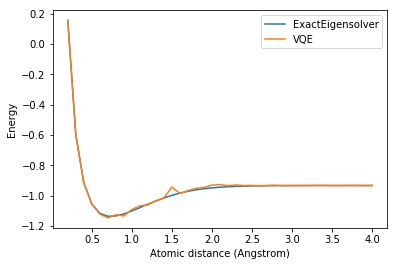

In [29]:
for i, algo in enumerate(algos):
    plt.plot(mol_distances, energy[i], label=algo)
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [ ]:
# -- TEST CODE BELOW -- #

In [8]:
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

distance = '0.8'

driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 {}'.format(distance), unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print('H .0 .0 .0; H .0 .0 {}'.format(distance))

print('Number of orbitals: {}'.format(molecule.num_orbitals))
print('Number of alpha electrons: {}'.format(molecule.num_orbitals))
print('Number of beta electrons: {}'.format(molecule.num_orbitals))

H .0 .0 .0; H .0 .0 0.8
Number of orbitals: 2
Number of alpha electrons: 2
Number of beta electrons: 2


In [9]:
import os, tempfile

fd, hdf5_file = tempfile.mkstemp(suffix='.hdf5', dir='/Users/logantillman/Desktop/qproj/H2')

os.close(fd)

molecule.save(hdf5_file)
print('{} : {} bytes'.format(hdf5_file, os.path.getsize(hdf5_file)))

/Users/logantillman/Desktop/qproj/H2/tmpi_rbovtw.hdf5 : 21768 bytes


In [10]:
driver = HDF5Driver(hdf5_file)
molecule1 = driver.run()

print('Number of orbitals: {}'.format(molecule1.num_orbitals))
print('Number of alpha electrons: {}'.format(molecule1.num_orbitals))
print('Number of beta electrons: {}'.format(molecule1.num_orbitals))

Number of orbitals: 2
Number of alpha electrons: 2
Number of beta electrons: 2


In [ ]:
os.remove(hdf5_file)